# Computational Intelligence Coursework - Ali

## Imports, Functions, Model, Data Loading

### Imports & Seed

In [1]:
# general imports
import numpy as np

# torch & data manipulation imports
import torch
from torch.utils.data import ConcatDataset, Subset, DataLoader
import torchvision
import torchvision.transforms as transforms

# model-related imports
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

# seed for reproducibility
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

/Users/alishihab/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Define Custom Preprocessing Functions

In [2]:
from torch.utils.data import Dataset

# DATA PREPROCESSING
class CustomDataset(Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, label = self.dataset[self.indices[idx]]
        if self.transform:
            image = self.transform(image)
        return image, label

# calculate mean & standard deviation based on dataset
def calc_mean_std(dataset):
    dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)
    mean_sum = 0.
    var_sum = 0.
    total_images_count = 0
    for images, _ in dataloader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean_sum += images.mean(2).sum(0)
        var_sum += images.var(2).sum(0)
        total_images_count += batch_samples

    mean = mean_sum / total_images_count
    var = var_sum / total_images_count
    std = np.sqrt(var)

    return mean, std

# define transformations for data augmentation
def train_transform(data, mean, std):
  data = normalize(data, mean, std)
  transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(0.25),
                                transforms.RandomVerticalFlip(0.25),
                                transforms.RandomGrayscale(0.25),
                                transforms.RandomCrop(32, padding=4)
                                 ])

  fred_transform = transforms.Compose([

                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                torchvision.transforms.RandomCrop(
                                    32, padding=4, padding_mode='reflect'),
                            ])
  return fred_transform(data)

# define normalisation
def normalize(data, mean, std):
  transform = transforms.Compose([
                                transforms.Normalize(mean, std)
                                ])
  return transform(data)

### Define Model Architecture

#### Ali's Net

In [21]:
class Net(nn.Module):
    def __init__(self, dropout_prob):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 32, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 32 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def freeze_all_but_last():
        for name, param in self.named_parameters():
            if 'fc2' not in name:
                param.requires_grad = False

    # Extract weights from the last layer
    def extract_weights():
        return [p.data.numpy() for p in self.fc2.parameters()]

#### Fred's Net

In [20]:
class Net2(nn.Module):
    def __init__(self, num_classes=10):
        super(Net2, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.batch_norm2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.1)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.batch_norm4 = nn.BatchNorm2d(128)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.relu5 = nn.ReLU()
        self.batch_norm5 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 256)
        self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
      #print("input", x.shape)
      x = self.conv1(x)
      x = self.relu1(x)
      x = self.batch_norm1(x)
      #print("conv1",x.shape)
      x = self.conv2(x)
      x = self.relu2(x)
      x = self.batch_norm2(x)
      #print("conv2",x.shape)
      x = self.conv3(x)
      x = self.relu3(x)
      x = self.batch_norm3(x)
      x = self.max_pool1(x)
      x = self.dropout1(x)
      #print("conv3",x.shape)
      x = self.conv4(x)
      x = self.relu4(x)
      x = self.batch_norm4(x)
      x = self.max_pool2(x)
     #print("conv4",x.shape)
      x = self.flatten(x)
      #print("flatten",x.shape)
      x = self.fc1(x)
      x = self.relu5(x)
      x = self.batch_norm5(x)
      #print("fc1",x.shape)
      x = self.fc2(x)
      #print("fc2",x.shape)

      x = self.dropout2(x)

      x = self.fc3(x)
      #print("fc3",x.shape)
      return x

    def freeze_all_but_last():
        for name, param in self.named_parameters():
            if 'fc3' not in name:
                param.requires_grad = False

    # Extract weights from the last layer
    def extract_weights():
        return [p.data.numpy() for p in self.fc3.parameters()]

### Checkpointing

In [4]:
def save_checkpoint(state, filename="checkpoint.pth.tar"):
    torch.save(state, filename)

### Data Loading & Preparation

In [5]:
# load CIFAR-10 dataset & convert to tensor
train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True,
                                         transform=transforms.ToTensor())

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True,
                                        transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# dataset hyperparameters
num_folds = 5
test_size = 0.20

# combine train and test datasets for stratified splitting
combined_set = ConcatDataset([train_set, test_set])

# STRATIFIED SPLIT
# collect the labels
labels = [y for _, y in combined_set]

# stratified split subset indices
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_idx, test_idx = next(sss.split(np.zeros(len(labels)), labels))

# subset using indices & collect associated labels
stratified_train_set, stratified_train_labels = Subset(combined_set, train_idx).dataset, [labels[i] for i in range(len(labels)) if i in train_idx]
stratified_test_set, stratified_test_labels = Subset(combined_set, test_idx).dataset, [labels[i] for i in range(len(labels)) if i in test_idx]

# create StratifiedKFold object for train set only
skf = StratifiedKFold(n_splits=num_folds)

## Baselines

### Gradient Based - Adam - Using Ali's Net

In [123]:
# function for training and evaluating the model
def adam_train_and_validate(model, train_loader, test_loader, criterion, optimizer, mean, std, epochs=30):
    model.to(device)
    model.train()

    # early stopping parameters
    early_stopping_patience = 5  # number of epochs to wait for improvement before stopping
    early_stopping_counter = 0    # counter for epochs without improvement
    best_accuracy = 0             # track the best accuracy
    loss_curve = []
    accuracy_curve = []

    # train
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        i = 0

        for inputs, train_load_labels in train_loader:
            inputs = train_transform(inputs, mean, std)
            inputs, train_load_labels = inputs.to(device), train_load_labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, train_load_labels)
            loss.backward()
            optimizer.step()

            loss_curve.append(loss.item())
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += train_load_labels.size(0)
            correct += (predicted == train_load_labels).sum().item()
            accuracy_curve.append(100 * correct / total)
            i += 1
            if i % 20 == 0:
              batch_accuracy = 100 * correct / total
              print(f'{i}th Batch Loss: {loss.item():.4f} Batch Accuracy: {batch_accuracy:.4f}')

        epoch_loss = running_loss / total
        epoch_accuracy = 100 * correct / total
        print(f'Epoch [{epoch + 1}/{epochs}] Loss: {loss.item():.4f} Epoch Accuracy: {epoch_accuracy:.4f}')

        model.eval()
        correct = 0
        total = 0

        # validate
        with torch.no_grad():
            for inputs, test_load_labels in test_loader:
                inputs = normalize(inputs, mean, std)
                inputs, test_load_labels = inputs.to(device), test_load_labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += test_load_labels.size(0)
                correct += (predicted == test_load_labels).sum().item()

        validation_accuracy = 100 * correct / total

        # check if the current validation accuracy is better than the best recorded accuracy
        if validation_accuracy > best_accuracy:
            best_accuracy = validation_accuracy
            early_stopping_counter = 0  # Reset the counter
            # save the model checkpoint
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, filename=f"best_model_epoch_{epoch+1}.pth.tar")
        else:
            early_stopping_counter += 1

        print(early_stopping_counter)
        # check if early stopping should be triggered
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

        print(f'Validation Accuracy: {validation_accuracy:.2f}%')
    return model, loss_curve, accuracy_curve

# function for testing the model
def test(model, test_loader, mean, std):

    model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, test_load_labels in test_loader:
            inputs = normalize(inputs, mean, std)
            inputs, test_load_labels = inputs.to(device), test_load_labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += test_load_labels.size(0)
            correct += (predicted == test_load_labels).sum().item()


    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return model

In [132]:
# Model hyperparameters
dropout_prob = 0.30
num_epochs = 20
batch_size = 128

model_adam = None
adam_loss = None
adam_accuracy = None
# call function
# Main loop for k-fold cross-validation
for fold, (train_fold_indices, val_fold_indices) in enumerate(skf.split(train_idx, stratified_train_labels)):
    print(f'Fold {fold + 1}/{num_folds}')
    mean, std = calc_mean_std(Subset(stratified_train_set, train_fold_indices))

    train_sampler = torch.utils.data.SubsetRandomSampler(train_fold_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_fold_indices)


    train_loader = torch.utils.data.DataLoader(
        dataset=stratified_train_set,
        batch_size=batch_size,
        sampler=train_sampler,
        worker_init_fn=seed_worker,
        generator=g)

    val_loader = torch.utils.data.DataLoader(
        dataset=stratified_train_set,
        batch_size=batch_size,
        sampler=val_sampler,
        worker_init_fn=seed_worker,
        generator=g)

    model_adam = Net2().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_adam.parameters(), lr=0.001)

    model_adam, adam_loss, adam_accuracy = adam_train_and_validate(model_adam, train_loader, val_loader, criterion, optimizer, mean, std, epochs=1)
    break

Fold 1/5


/Users/alishihab/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/alishihab/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


20th Batch Loss: 1.7246 Batch Accuracy: 31.1719
40th Batch Loss: 1.6599 Batch Accuracy: 34.8242
60th Batch Loss: 1.5993 Batch Accuracy: 38.6198
80th Batch Loss: 1.3599 Batch Accuracy: 40.4492
100th Batch Loss: 1.4040 Batch Accuracy: 41.8203
120th Batch Loss: 1.3419 Batch Accuracy: 43.3073
140th Batch Loss: 1.2452 Batch Accuracy: 44.4308
160th Batch Loss: 1.2424 Batch Accuracy: 45.5615
180th Batch Loss: 1.4195 Batch Accuracy: 46.3802
200th Batch Loss: 1.1661 Batch Accuracy: 47.1992
220th Batch Loss: 1.2096 Batch Accuracy: 47.7983
240th Batch Loss: 1.1341 Batch Accuracy: 48.6133
260th Batch Loss: 1.1229 Batch Accuracy: 49.3359
280th Batch Loss: 1.1695 Batch Accuracy: 50.1256
300th Batch Loss: 0.9739 Batch Accuracy: 50.8646
Epoch [1/1] Loss: 0.9739 Epoch Accuracy: 50.8646
0
Validation Accuracy: 63.04%


In [127]:
# test model
test_loader = torch.utils.data.DataLoader(
    dataset=stratified_test_set,
    batch_size=batch_size,
    worker_init_fn=seed_worker,
    generator=g)

test(model_adam, test_loader, mean, std)

Test Accuracy: 64.90%


Net2(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (batch_norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (batch_norm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False

## Population Based - Genetic Algorithm

## Proposed - Adaptive Baldwinian-Lamarckian Memetic Algorithm
## Adam-guided Adaptive-SL-PSO

### Imports, Preprocessing & Definitions

In [10]:
import operator
import random
from matplotlib import pyplot as plt
import math
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools
from numba import jit, cuda
from numpy import genfromtxt

In [11]:
def neighbour_search(pop, individual, neighbours=10):
    distances = {}
    for i, part in enumerate(pop):
        # print(f"part: {len(part)} individual: {len(individual)}")
        if individual != part:
            distance = np.linalg.norm(np.array(part)-np.array(individual))
            if len(distances) < neighbours:
                distances[i] = distance
            else:
                copy = distances.copy()
                for e in copy.keys():
                    if distances[e] > distance:
                        distances[i] = distance
                        del distances[e]
                        break
    neighbourhood = [pop[i] for i in distances.keys()]
    sort_population(neighbourhood, potential=True)
    return neighbourhood

# Ali's functions for question 3 ----------------------------------------------------------------
def sort_population(population, potential=False):
    if potential:
        population.sort(key=lambda x: x.potential[0])
    else:
        population.sort(key=lambda x: x.fitness.values[0])

In [97]:
# Function to freeze all but the last layer
def freeze_all_but_last(model):
    for name, param in model.named_parameters():
        if 'fc3' not in name:
            param.requires_grad = False

# Extract weights from the last layer
def extract_weights_biases(layer):
    return [p.data.numpy() for p in layer.parameters()]

def generate_particle(dimension):
    part = creator.Particle([random.uniform(-1, 1) for _ in range(dimension)])
    part.speed = [random.uniform(-1, 1) for _ in range(dimension)]
    part.smin = -1
    part.smax = 1
    return part

# Define the fitness function
def evaluate_particle(model, particle, inputs, labels, best=False):
    weights = np.asarray(particle, dtype=np.float32)
    new_weights = torch.from_numpy(weights[:weights_len].reshape(weights_dim))
    new_biases = torch.from_numpy(weights[weights_len:dimension])
    new_weights = new_weights.to(device)
    new_biases = new_biases.to(device)
    model.fc3.weight = torch.nn.Parameter(new_weights)
    model.fc3.bias = torch.nn.Parameter(new_biases)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    inputs, labels = torch.FloatTensor(inputs), torch.Tensor(labels)
    inputs, labels, model = inputs.to(device), labels.to(device), model.to(device)
    optimizer.zero_grad()  # clear gradients for next train

    # fitness
    outputs = model(inputs)  # input and predict based on images
    loss = criterion(outputs, labels)
    fitness = loss.item(),
    
    # potential
    loss.backward()  # backpropagation, compute gradients
    optimizer.step()  # apply gradients
    optimizer.zero_grad()  # clear gradients for next train
    outputs = model(inputs)  # input and predict based on images
    loss = criterion(outputs, labels)
    potential = loss.item(),

    if best:
            # potential turns into fitness
            fitness = potential

            # and next gradient descent becomes the potential
            loss.backward()  # backpropagation, compute gradients
            optimizer.step()  # apply gradients
            optimizer.zero_grad()  # clear gradients for next train
            outputs = model(inputs)  # input and predict based on images
            loss = criterion(outputs, labels)
            potential = loss.item(),

            demonstrator_weights = model.fc3.weight.data.to('cpu').reshape(-1)
            demosntrator_biases = model.fc3.bias.data.to('cpu').reshape(-1)
            new_lamarckian = np.concatenate((demonstrator_weights, demosntrator_biases))
            new_particle = creator.Particle(new_lamarckian)
            new_particle.fitness.values = fitness
            new_particle.potential = potential
            
            return new_particle
    else:
            particle.fitness.values = fitness
            particle.potential = potential
    #return loss.item(),

# social learning in a neighbourhood of size
def behaviour_learning(gamma, gbest, part, pop, mu, epsilon, neighbours=10):
    i = pop.index(part)
    neighbour_pop = neighbour_search(pop, part, neighbours)

    index = None
    for j in range(len(neighbour_pop)-1, -1, -1):
        if neighbour_pop[j].potential[0] <= part.potential[0]:
            index = j
            break


    demonstrator = None

    if (i != 0) & (index is not None):
        if index != 0:
                k = math.floor(random.randrange(0, index))
                demonstrator = neighbour_pop[k]
        else:
                k = index
                demonstrator = neighbour_pop[k]
    else:
        demonstrator = [sum(np.asarray(neighbour_pop)[:,x])/populationSize for x in range(dimension)]
        demonstrator = -1*np.asarray(demonstrator)

    r1 = (random.uniform(0, 1) for _ in range(len(part)))
    r2 = (random.uniform(0, 1) for _ in range(len(part)))
    r3 = (random.uniform(0, 1) for _ in range(len(part)))
    ones = [1] * len(part)
    one_minus_gamma = np.asarray(ones) - gamma

    v_r0 = list(map(operator.mul, r1, part.speed))
    v_r1 = list(map(operator.mul, r2, map(operator.sub, demonstrator, part))) # local best
    v_r2 = list(map(operator.mul,r3, map(operator.mul, [epsilon*x for x in mu], part))) # global best

    sl_speed = list(map(operator.add, v_r1, v_r2))
    exploitation_speed = gamma*np.asarray(gbest)
    exploration_speed = list(map(operator.mul, one_minus_gamma, sl_speed))

    new_speed = list(map(operator.add, v_r0 , map(operator.add, exploitation_speed, exploration_speed)))
    new_part = list(map(operator.add, part, part.speed))

    return new_part, new_speed

In [106]:
def pso_optimize(model, toolbox, pop, inputs, labels, batch, fits):
    interval        = 50
    iterations      = 20
    neighbours = 10
    beta = 0.01
    alpha = 0.5

    m = populationSize + math.floor(dimension/10)
    epsilon = beta * (dimension/populationSize)

    gbest = None
    new_weights = None
    new_biases = None

    # eval current fitness - only on the first run
    if batch == 1:
        for part in pop:
            toolbox.evaluate(model, part, inputs, labels) #actually only one fitness value

        # find the global best - lamarckian search party lead - gradient descent
        sort_population(pop, potential=False)
        gbest = pop[0]

        # sort the the baldwinian search participants by their potential, leave the current global best as the lamarckian search-lead
        sort_population(pop[1:], potential=True)
    else:
        gbest = pop[0]

    # begin the evolution
    #for g in range(iterations):

    # a new Search
    print("-- Search %i --" % batch)

    print(f'current gbest: {gbest.fitness.values[0]}, current worst: {pop[-1].fitness.values[0]}')

    # parameter setting
    mu = [sum(np.asarray(pop)[:,x])/populationSize for x in range(dimension)]
    gamma = min((gbest.fitness.values[0]-gbest.potential[0])/np.std(fits), 1) if len(fits) > 5 else (1-(gbest.fitness.values[0]/pop[-2].fitness.values[0]))
    i = 0

    # evolve the local-search-groups via SL-PSO algorithm
    for part in pop[1:]:
        i = i + 1
        learn_prob = (1 - (i-1)/m)**(alpha*math.log(math.ceil(dimension/m)))
        if random.random() < learn_prob:
            part[:], part.speed = toolbox.learn(gamma, gbest, part, pop[1:], mu, epsilon, neighbours)
            toolbox.evaluate(model, part, inputs, labels) # evaluate fitness & potential


    # evolve the lamarckian lead
    pop[0] = toolbox.evaluate(model, pop[0], inputs, labels, best=True) #actually only one fitness value

    # find the global best - lamarckian search party lead - gradient descent
    sort_population(pop, potential=False)
    gbest = pop[0]

    # sort the the baldwinian search participants by their potential, leave the current global best as the lamarckian search-lead
    sort_population(pop[1:], potential=True)

    print(f'gbest after evolution: {gbest.fitness.values[0]}, worst after evolution: {pop[-1].fitness.values[0]}')

    # set weights to best individual
    weights = np.asarray(gbest)
    new_weights = torch.from_numpy(weights[:weights_len].reshape(weights_dim)).to(device)
    new_biases = torch.from_numpy(weights[weights_len:dimension]).to(device)

    # Gather all the fitnesses in one list and print the stats
    # print every interval
    fits.append(gbest.fitness.values[0])
    if batch%interval==0: # interval
        logbook.record(gen=g, evals=len(pop), **stats.compile(pop))
        print(logbook.stream)
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5


        print("  Min %s" % min(fits))
        print("  Max %s" % max(fits))
        print("  Avg %s" % mean)
        print("  Std %s" % std)
        plt.plot(fits)
    return new_weights, new_biases, pop

In [108]:
# function for training and evaluating the model
def memetic_train_and_validate(model, toolbox, pop, train_loader, test_loader, criterion, optimizer, mean, std, fits, epochs=30):
    model.to(device)
    model.eval() # turn off dropout layers

    # early stopping parameters
    early_stopping_patience = 3  # number of epochs to wait for improvement before stopping
    early_stopping_counter = 0    # counter for epochs without improvement
    best_accuracy = 0             # track the best accuracy
    loss_curve = []  # track loss curve
    accuracy_curve = []  # track accuracy curve

    # train
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        i = 0

        for inputs, train_load_labels in train_loader:
            inputs = train_transform(inputs, mean, std)
            #inputs, train_load_labels = inputs.to(device), train_load_labels.to(device)
            i += 1
            new_weights, new_biases, pop = pso_optimize(model, toolbox, pop, inputs, train_load_labels, i, fits)
            model.fc3.weight = torch.nn.Parameter(new_weights)
            model.fc3.biases = torch.nn.Parameter(new_biases)
            inputs, train_load_labels = inputs.to(device), train_load_labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, train_load_labels)
            loss_curve.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            running_loss += loss.item()
            total += train_load_labels.size(0)
            correct += (predicted == train_load_labels).sum().item()
            #if i % 20 == 0:
            batch_accuracy = 100 * correct / total
            accuracy_curve.append(batch_accuracy)
            print(f'{i}th Batch Loss: {loss.item():.4f} Batch Accuracy: {batch_accuracy:.4f}')

        epoch_accuracy = 100 * correct / total
        print(f'Epoch [{epoch + 1}/{epochs}] Loss: {loss.item():.4f} Epoch Accuracy: {epoch_accuracy:.4f}')

        model.eval()
        correct = 0
        total = 0

        # validate
        with torch.no_grad():
            for inputs, test_load_labels in test_loader:
                #inputs = normalize(inputs, mean, std)
                inputs, test_load_labels = inputs.to(device), test_load_labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += test_load_labels.size(0)
                correct += (predicted == test_load_labels).sum().item()

        validation_accuracy = 100 * correct / total

        # check if the current validation accuracy is better than the best recorded accuracy
        if validation_accuracy > best_accuracy:
            best_accuracy = validation_accuracy
            early_stopping_counter = 0  # Reset the counter
            # save the model checkpoint
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, filename=f"best_model_epoch_{epoch+1}.pth.tar")
        else:
            early_stopping_counter += 1

        print(early_stopping_counter)
        # check if early stopping should be triggered
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

        print(f'Validation Accuracy: {validation_accuracy:.2f}%')
    return model, loss_curve, accuracy_curve

In [109]:
best_checkpoint = torch.load("best_model_epoch_19.pth.tar")  # Replace X with the epoch number
model = Net2()
model.load_state_dict(best_checkpoint['state_dict'])

<All keys matched successfully>

Fold 1/5


/Users/alishihab/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/alishihab/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


-- Search 1 --
current gbest: 21.379575729370117, current worst: 50.685768127441406
gbest after evolution: 21.010047912597656, worst after evolution: 73.06380462646484
1th Batch Loss: 20.6419 Batch Accuracy: 20.3125
-- Search 2 --
current gbest: 21.010047912597656, current worst: 73.06380462646484
gbest after evolution: 16.927888870239258, worst after evolution: 72.21127319335938
2th Batch Loss: 16.6436 Batch Accuracy: 22.6562
-- Search 3 --
current gbest: 16.927888870239258, current worst: 72.21127319335938
gbest after evolution: 19.501853942871094, worst after evolution: 80.71591186523438
3th Batch Loss: 19.1672 Batch Accuracy: 21.0938
-- Search 4 --
current gbest: 19.501853942871094, current worst: 80.71591186523438
gbest after evolution: 13.268749237060547, worst after evolution: 80.71591186523438
4th Batch Loss: 13.0436 Batch Accuracy: 23.0469
-- Search 5 --
current gbest: 13.268749237060547, current worst: 80.71591186523438
gbest after evolution: 17.88948631286621, worst after ev

/var/folders/sc/1szcwj896vj46hym37x0wkzc0000gn/T/ipykernel_11959/200355394.py:20: RuntimeWarning: overflow encountered in cast
  weights = np.asarray(particle, dtype=np.float32)


gbest after evolution: 7.064163684844971, worst after evolution: nan
25th Batch Loss: 6.8873 Batch Accuracy: 29.2812
-- Search 26 --
current gbest: 7.064163684844971, current worst: nan
gbest after evolution: 7.971489906311035, worst after evolution: nan
26th Batch Loss: 7.7444 Batch Accuracy: 29.8077
-- Search 27 --
current gbest: 7.971489906311035, current worst: nan
gbest after evolution: 6.170391082763672, worst after evolution: nan
27th Batch Loss: 6.0130 Batch Accuracy: 30.4688
-- Search 28 --
current gbest: 6.170391082763672, current worst: nan
gbest after evolution: 6.450237274169922, worst after evolution: nan
28th Batch Loss: 6.2576 Batch Accuracy: 30.9989
-- Search 29 --
current gbest: 6.450237274169922, current worst: nan
gbest after evolution: 8.041728019714355, worst after evolution: nan
29th Batch Loss: 7.8503 Batch Accuracy: 31.2769
-- Search 30 --
current gbest: 8.041728019714355, current worst: nan


/var/folders/sc/1szcwj896vj46hym37x0wkzc0000gn/T/ipykernel_11959/200355394.py:104: RuntimeWarning: overflow encountered in scalar multiply
  v_r2 = list(map(operator.mul,r3, map(operator.mul, [epsilon*x for x in mu], part))) # global best


gbest after evolution: 6.077485084533691, worst after evolution: nan
30th Batch Loss: 5.9006 Batch Accuracy: 31.9531
-- Search 31 --
current gbest: 6.077485084533691, current worst: nan


/var/folders/sc/1szcwj896vj46hym37x0wkzc0000gn/T/ipykernel_11959/200355394.py:110: RuntimeWarning: invalid value encountered in scalar add
  new_speed = list(map(operator.add, v_r0 , map(operator.add, exploitation_speed, exploration_speed)))
/var/folders/sc/1szcwj896vj46hym37x0wkzc0000gn/T/ipykernel_11959/200355394.py:106: RuntimeWarning: invalid value encountered in scalar add
  sl_speed = list(map(operator.add, v_r1, v_r2))
/var/folders/sc/1szcwj896vj46hym37x0wkzc0000gn/T/ipykernel_11959/200355394.py:93: RuntimeWarning: invalid value encountered in scalar add
  demonstrator = [sum(np.asarray(neighbour_pop)[:,x])/populationSize for x in range(dimension)]


gbest after evolution: 6.871692657470703, worst after evolution: nan
31th Batch Loss: 6.6655 Batch Accuracy: 32.3589
-- Search 32 --
current gbest: 6.871692657470703, current worst: nan


/var/folders/sc/1szcwj896vj46hym37x0wkzc0000gn/T/ipykernel_11959/3491565199.py:38: RuntimeWarning: invalid value encountered in scalar add
  mu = [sum(np.asarray(pop)[:,x])/populationSize for x in range(dimension)]
/var/folders/sc/1szcwj896vj46hym37x0wkzc0000gn/T/ipykernel_11959/959697646.py:6: RuntimeWarning: invalid value encountered in subtract
  distance = np.linalg.norm(np.array(part)-np.array(individual))
/var/folders/sc/1szcwj896vj46hym37x0wkzc0000gn/T/ipykernel_11959/200355394.py:103: RuntimeWarning: invalid value encountered in scalar subtract
  v_r1 = list(map(operator.mul, r2, map(operator.sub, demonstrator, part))) # local best


gbest after evolution: 5.381437301635742, worst after evolution: nan
32th Batch Loss: 5.2033 Batch Accuracy: 32.7637
-- Search 33 --
current gbest: 5.381437301635742, current worst: nan


/var/folders/sc/1szcwj896vj46hym37x0wkzc0000gn/T/ipykernel_11959/959697646.py:6: RuntimeWarning: overflow encountered in subtract
  distance = np.linalg.norm(np.array(part)-np.array(individual))


gbest after evolution: 5.604665279388428, worst after evolution: nan
33th Batch Loss: 5.4546 Batch Accuracy: 33.4991
-- Search 34 --
current gbest: 5.604665279388428, current worst: nan


/var/folders/sc/1szcwj896vj46hym37x0wkzc0000gn/T/ipykernel_11959/3491565199.py:38: RuntimeWarning: overflow encountered in scalar add
  mu = [sum(np.asarray(pop)[:,x])/populationSize for x in range(dimension)]


gbest after evolution: 4.589725017547607, worst after evolution: nan
34th Batch Loss: 4.4452 Batch Accuracy: 34.0533
-- Search 35 --
current gbest: 4.589725017547607, current worst: nan
gbest after evolution: 5.381180763244629, worst after evolution: nan
35th Batch Loss: 5.2287 Batch Accuracy: 34.5312
-- Search 36 --
current gbest: 5.381180763244629, current worst: nan
gbest after evolution: 5.394583702087402, worst after evolution: nan
36th Batch Loss: 5.2300 Batch Accuracy: 34.9826
-- Search 37 --
current gbest: 5.394583702087402, current worst: nan


/var/folders/sc/1szcwj896vj46hym37x0wkzc0000gn/T/ipykernel_11959/200355394.py:93: RuntimeWarning: overflow encountered in scalar add
  demonstrator = [sum(np.asarray(neighbour_pop)[:,x])/populationSize for x in range(dimension)]


gbest after evolution: 6.039957523345947, worst after evolution: nan
37th Batch Loss: 5.8957 Batch Accuracy: 35.3041
-- Search 38 --
current gbest: 6.039957523345947, current worst: nan
gbest after evolution: 3.891465663909912, worst after evolution: nan
38th Batch Loss: 3.7760 Batch Accuracy: 35.9375
-- Search 39 --
current gbest: 3.891465663909912, current worst: nan
gbest after evolution: 3.788607358932495, worst after evolution: nan
39th Batch Loss: 3.6520 Batch Accuracy: 36.4383
-- Search 40 --
current gbest: 3.788607358932495, current worst: nan
gbest after evolution: 5.820739269256592, worst after evolution: nan
40th Batch Loss: 5.6680 Batch Accuracy: 36.7188
-- Search 41 --
current gbest: 5.820739269256592, current worst: nan
gbest after evolution: 5.278689384460449, worst after evolution: nan
41th Batch Loss: 5.1422 Batch Accuracy: 37.1570
-- Search 42 --
current gbest: 5.278689384460449, current worst: nan
gbest after evolution: 4.736695289611816, worst after evolution: nan
4

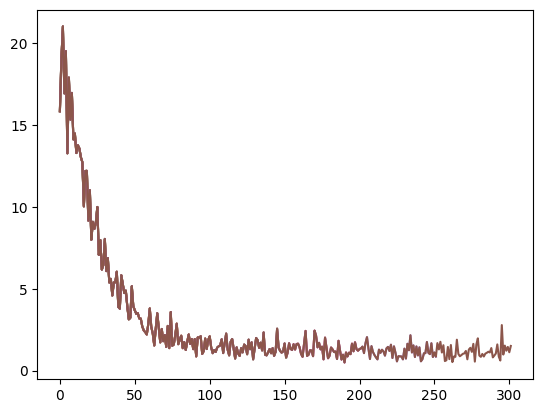

In [110]:
fc3_weights = model.fc3.weight.data
weights_dim = fc3_weights.shape
weights_len = len(fc3_weights.reshape(-1))
fc3_bias = model.fc3.bias.data
bias_dim = fc3_bias.shape
bias_len = len(fc3_bias.reshape(-1))
populationSize  = 100
dimension = weights_len + bias_len

# Freeze all layers except the last
freeze_all_but_last(model)
if "Particle" in dir(creator) or "FitnessMin" in dir(creator):
    del creator.Particle, creator.FitnessMin


# DEAP inits
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Particle", list, fitness=creator.FitnessMin, speed=list,
                smin=None, smax=None, best=None, potential=None)

toolbox = base.Toolbox()
toolbox.register("particle", generate_particle, dimension)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)
toolbox.register("evaluate", evaluate_particle)
toolbox.register("learn", behaviour_learning)

# Model hyperparameters
dropout_prob = 0.30
num_epochs = 20
batch_size = 128

loss_curve = None
accuracy_curve = None

# call function
# Main loop for k-fold cross-validation
for fold, (train_fold_indices, val_fold_indices) in enumerate(skf.split(train_idx, stratified_train_labels)):
    print(f'Fold {fold + 1}/{num_folds}')
    mean, std = calc_mean_std(Subset(stratified_train_set, train_fold_indices))

    train_sampler = torch.utils.data.SubsetRandomSampler(train_fold_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_fold_indices)

    # create an initial population of individuals
    pop = toolbox.population(n=populationSize)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)


    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields

    train_loader = torch.utils.data.DataLoader(
        dataset=stratified_train_set,
        batch_size=batch_size,
        sampler=train_sampler,
        worker_init_fn=seed_worker,
        generator=g)

    val_loader = torch.utils.data.DataLoader(
        dataset=stratified_train_set,
        batch_size=batch_size,
        sampler=val_sampler,
        worker_init_fn=seed_worker,
        generator=g)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model, loss_curve, accuracy_curve = memetic_train_and_validate(model, toolbox, pop, train_loader, val_loader, criterion, optimizer, mean, std, fits, epochs=1)
    break

## Test Model

In [122]:
# test model
test_loader = torch.utils.data.DataLoader(
    dataset=stratified_test_set,
    batch_size=batch_size,
    worker_init_fn=seed_worker,
    generator=g)

test(model, test_loader, mean, std)

Test Accuracy: 86.12%


Net2(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (batch_norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (batch_norm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False

## Save the model

In [111]:
# save the model checkpoint
save_checkpoint({
    'epoch': 300,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}, filename=f"proposed_optimizer_model.pth.tar")

## Save the results & population

In [115]:
import pandas
df_loss = pandas.DataFrame(loss_curve)
df_accuracy = pandas.DataFrame(accuracy_curve)
df_fits = pandas.DataFrame(fits)
df_loss.to_csv('loss_curve.csv', index=False, header=False )
df_accuracy.to_csv('accuracy_curve.csv', index=False, header=False )
df_fits.to_csv('fits_curve.csv', index=False, header=False )

In [116]:
import csv

# save population to csv
with open('population.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for individual in pop:
        writer.writerow(individual)  # Write the individual's attributes

In [117]:
with open('logbook.csv', 'w', newline='') as csvfile:
    # If logbook entries are dictionaries, get the keys for column headers
    if logbook:
        headers = list(logbook[0].keys())
        writer = csv.DictWriter(csvfile, fieldnames=headers)
        writer.writeheader()
        for entry in logbook:
            writer.writerow(entry)

## Plot results

In [134]:
# normlise data

# Convert list to NumPy array
normed_accuracy_curve = np.array(accuracy_curve)
normed_loss_curve = np.array(loss_curve)
normed_adam_accuracy = np.array(adam_accuracy)
normed_adam_loss = np.array(adam_loss)

# Apply Min-Max Normalization
accuracy_min_val = normed_accuracy_curve.min()
accuracy_max_val = normed_accuracy_curve.max()
# Apply Min-Max Normalization
adam_accuracy_min_val = normed_adam_accuracy.min()
adam_accuracy_max_val = normed_adam_accuracy.max()

loss_min_val = normed_loss_curve.min()
loss_max_val = normed_loss_curve.max()
adam_loss_min_val = normed_adam_loss.min()
adam_loss_max_val = normed_adam_loss.max()

scaled_accuracy = (normed_accuracy_curve - accuracy_min_val) / (accuracy_max_val - accuracy_min_val)
scaled_loss = (normed_loss_curve - loss_min_val) / (loss_max_val - loss_min_val)
adam_scaled_accuracy = (normed_adam_accuracy - adam_accuracy_min_val) / (adam_accuracy_max_val - adam_accuracy_min_val)
adam_scaled_loss = (normed_adam_loss - adam_loss_min_val) / (adam_loss_max_val - adam_loss_min_val)

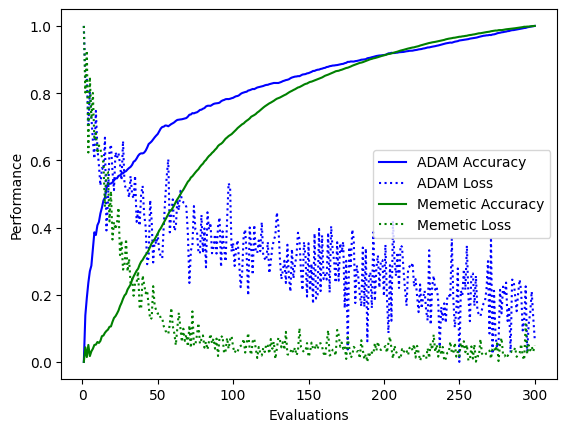

In [135]:
import matplotlib.pyplot as plt

# Example data
epochs = list(range(1, 301))  # Replace with your actual x-axis values
#blue_solid_data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Replace with your data
#blue_dotted_data = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]  # Replace with your data

# Plotting
plt.plot(epochs, adam_scaled_accuracy, color='blue', linestyle='-', label='ADAM Accuracy')
plt.plot(epochs, adam_scaled_loss, color='blue', linestyle=':', label='ADAM Loss')
plt.plot(epochs, scaled_accuracy, color='green', linestyle='-', label='Memetic Accuracy')
plt.plot(epochs, scaled_loss, color='green', linestyle=':', label='Memetic Loss')

# Labeling Axes
plt.xlabel('Evaluations')
plt.ylabel('Performance')

# Adding a Legend
plt.legend()

# Show the plot
plt.show()

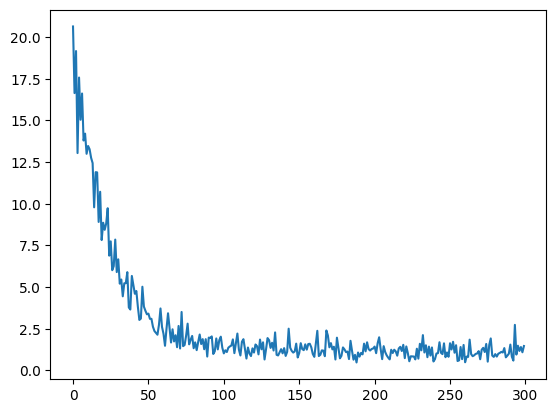

In [112]:
plt.plot(loss_curve)

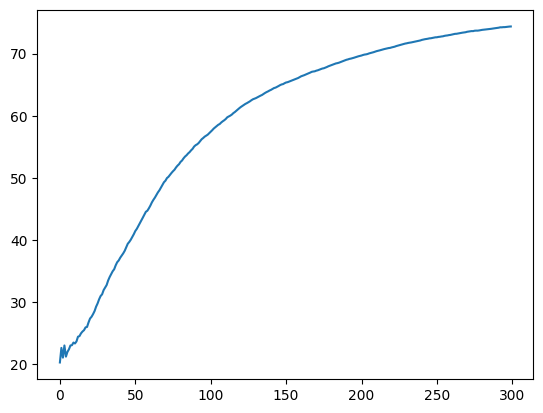

In [113]:
plt.plot(accuracy_curve)

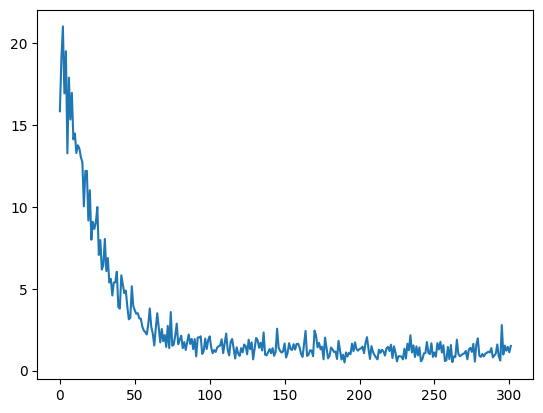

In [114]:
plt.plot(fits)